# GeoMAD

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual), [gm_s2_semiannual](https://explorer.digitalearth.africa/gm_s2_semiannual), [gm_ls8_ls9_annual](https://explorer.digitalearth.africa/products/gm_ls8_ls9_annual), [gm_ls8_annual](https://explorer.digitalearth.africa/gm_ls8_annual), [gm_ls5_ls7_annual](https://explorer.digitalearth.africa/gm_ls5_ls7_annual), 


## Background

Satellite imagery allows us to observe the Earth with significant accuracy and detail. However, missing data &mdash; such as gaps caused by cloud cover &mdash; can make it difficult to put together a complete image. 

In order to produce a single, complete view of a certain area, satellite data must be consolidated, stacking measurements from different points in time to create a composite image.

The Digital Earth Africa (DE Africa) GeoMAD (**Geo**median and **M**edian **A**bsolute **D**eviations) is a cloud-free composite of satellite data compiled for over annual and semi-annual (six-month) periods during each calendar year.

The following GeoMAD products are available on DE Africa platforms:

* `gm_s2_annual`: Annual (calendar year) GeoMAD composite using Sentinel-2 imagery, available for the years **2017 - present**
* `gm_s2_semiannual`: bi-annual (Jan-Jun, Jul-Dec) GeoMAD composites using Sentinel-2 imagery, available for the years **2017 - present**
* `gm_ls8_ls9_annual`: Annual (calendar year) GeoMAD composite using Landsat-8 and Landsat-9 imagery, available for the years **2021 - present**
* `gm_ls8_annual`: Annual (calendar year) GeoMAD composite using Landsat-8 imagery, available for the years **2013 - 2020**
* `gm_ls5_ls7_annual`: Annual (calendar year) GeoMAD composite combining both Landsat-5 and Landsat-7 imagery, available for the years **1984 - 2012**

Each product combines measurements collected over a defined period (annual or semi-annual) to produce one representative, multi-spectral image for every pixel of the African continent. The end result is a comprehensive dataset that can be used either to generate true-colour images for visual inspection of the landsacpe, or the full spectral dataset can be used to develop more complex algorithms.  

To produce a GeoMAD composite, for each pixel, invalid data is discarded, and the remaining observations are mathematically summarised using a high-dimensional geomedian statistic. GeoMAD also includes three measures of Median Absolute Deviation (MAD). These are higher-order statistical measurements on variation relative to the geomedian, pre-calculated at the same annual time scale. These layers can be used on their own or together with geomedian to gain insights about the land surface and understand its change over time. For a detailed description on how the GeoMAD is calculated, see the [GeoMAD technical specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html).

**Important details:**

* Datacube product names: `gm_s2_annual`, `gm_s2_semiannual`, `gm_ls8_ls9_annual`, `gm_ls8_annual`, `gm_ls5_ls7_annual`
* Geomedian surface reflectance product
    * Valid scaling range: `1 - 10,000`
    * `0` is `no data`
* Median Absolute Deviation product
    * Valid scaling range: Spectral MAD: `0 - 1` , Bray-Curtis MAD `0 - 1`, Euclidean MAD `0 - 10,000` 
    * `NaN` is `nodata`
* Status: Operational
* Date-range: 1984 &ndash; present
* Spatial resolution: 10m for S2 products, 30m for Landsat products

>Note: For a detailed description of DE Africa's GeoMAD service, see the DE Africa [GeoMAD technical specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html).

## Description

In this notebook we will load GeoMAD data using `dc.load()` to return a time series of satellite images. The returned xarray.Dataset will contain analysis-ready images.

Topics covered include:
1. Inspecting the GeoMAD products and measurements available in the datacube
2. Using the native `dc.load()` function to load in GeoMAD data
    * Geomedian surface reflectance example
    * Median Absolute Deviations example
3. A simple example anlaysis using GeoMAD 
4. An interactive widget for understanding the geomedian statistic

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube
import numpy as np
import matplotlib.pyplot as plt

from deafrica_tools.plotting import rgb
from deafrica_tools.app import geomedian

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='GeoMAD')

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect the DE Africa GeoMAD products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
# List Sentinel-2 products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'gm').fillna(
        False)][display_columns].set_index('name')

,description
name,
gm_ls5_ls7_annual,Surface Reflectance Annual Geometric Median an...
gm_ls5_ls7_annual_lowres,Surface Reflectance Annual Geometric Median an...
gm_ls8_annual,Surface Reflectance Annual Geometric Median an...
gm_ls8_annual_lowres,Surface Reflectance Annual Geometric Median an...
gm_ls8_ls9_annual,Surface Reflectance Annual Geometric Median an...
gm_ls8_ls9_annual_lowres,Surface Reflectance Annual Geometric Median an...
gm_s2_annual,Surface Reflectance Annual Geometric Median an...
gm_s2_annual_lowres,"Annual Geometric Median, Sentinel-2 - Low Reso..."
gm_s2_semiannual,Surface Reflectance Semiannual Geometric Media...


### List measurements

We can further inspect the data available for GeoMAD using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data. 

Below, enter the name of the product you would like to see the measurements of. In the default example, we will examine `gm_s2_annual`, the Sentinel-2 Annual GeoMAD service.


In [4]:
product_name = 'gm_s2_annual'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,name,dtype,units,nodata,aliases
measurement,,,,,
B02,B02,uint16,1,0.0,"[band_02, blue]"
B03,B03,uint16,1,0.0,"[band_03, green]"
B04,B04,uint16,1,0.0,"[band_04, red]"
B05,B05,uint16,1,0.0,"[band_05, red_edge_1]"
B06,B06,uint16,1,0.0,"[band_06, red_edge_2]"
B07,B07,uint16,1,0.0,"[band_07, red_edge_3]"
B08,B08,uint16,1,0.0,"[band_08, nir, nir_1]"
B8A,B8A,uint16,1,0.0,"[band_8a, nir_narrow, nir_2]"
B11,B11,uint16,1,0.0,"[band_11, swir_1, swir_16]"


Let's also inpsect the measurements of the Landsat 8-9 GeoMAD, `gm_ls8_ls9_annual`

In [5]:
product_name = 'gm_ls8_ls9_annual'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,name,dtype,units,nodata,aliases
measurement,,,,,
SR_B2,SR_B2,uint16,1,0.0,"[band_2, blue]"
SR_B3,SR_B3,uint16,1,0.0,"[band_3, green]"
SR_B4,SR_B4,uint16,1,0.0,"[band_4, red]"
SR_B5,SR_B5,uint16,1,0.0,"[band_5, nir]"
SR_B6,SR_B6,uint16,1,0.0,"[band_6, swir_1]"
SR_B7,SR_B7,uint16,1,0.0,"[band_7, swir_2]"
SMAD,SMAD,float32,1,NaN,"[smad, sdev, SDEV]"
EMAD,EMAD,float32,1,NaN,"[emad, edev, EDEV]"
BCMAD,BCMAD,float32,1,NaN,"[bcmad, bcdev, BCDEV]"


## Load GeoMAD data using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

### Example 1: Surface reflectance

In the first example below, we will load GeoMAD data from the Eye of Africa in the Sahara Desert, Mauritania, from 2020. We will load data from three spectral satellite bands: `red`, `green`, and `blue`.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [6]:
# load data
ds = dc.load(product="gm_s2_annual",
             measurements=['red', 'green', 'blue'],
             x=(-11.50, -11.27),
             y=(21.00, 21.20),
             time=("2020")
             )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 2385, x: 2220)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 2.645e+06 2.645e+06 ... 2.621e+06 2.621e+06
  * x            (x) float64 -1.11e+06 -1.11e+06 ... -1.087e+06 -1.087e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1933 1956 1979 2006 ... 4392 4413 4439 4458
    green        (time, y, x) uint16 1451 1472 1491 1511 ... 2833 2847 2868 2879
    blue         (time, y, x) uint16 1039 1054 1064 1073 ... 1695 1709 1719 1724
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref



### Plotting GeoMAD geomedian data

We can plot the data we loaded using the `deafrica_tools.plotting.rgb()` function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.


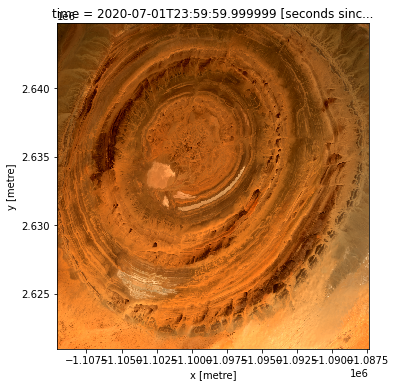

In [7]:
rgb(ds)

### Example 2 - Median Absolute Deviations

In this example, we load the Median Absolute Deviation (MAD) bands of data and plot a false-colour map using those three bands. The area selected a farming district around Oum Er-Rbia Rover in Morocco.

In [8]:
# load data
lat, lon = 32.4493, -7.4236
buffer = 0.05

ds = dc.load(product="gm_s2_annual",
             measurements=['red','green','blue','smad','emad', 'bcmad'],
             x= (lon-buffer, lon+buffer),
             y=(lat+buffer, lat-buffer),
             time=("2020")
             )
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 1081, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 3.932e+06 3.932e+06 ... 3.922e+06 3.922e+06
  * x            (x) float64 -7.211e+05 -7.211e+05 ... -7.115e+05 -7.115e+05
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 2940 2948 2945 2934 ... 2940 2903 2879 2862
    green        (time, y, x) uint16 1798 1802 1803 1795 ... 1916 1893 1876 1858
    blue         (time, y, x) uint16 1114 1118 1118 1110 ... 1275 1253 1237 1224
    smad         (time, y, x) float32 0.0002043 0.000197 ... 0.0001852 0.0001878
    emad         (time, y, x) float32 719.1 734.2 745.5 ... 754.0 740.9 744.1
    bcmad        (time, y, x) float32 0.03218 0.03213 0.03373 ... 0.0337 0.03397
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Plotting GeoMAD MAD data

MAD data has three bands (SMAD, EMAD, BCMAD) and is therefore well-suited to being visualised in false-colour. This means each of the MADs is assigned to one of the red, green, and blue colour channels of the image.

Inspecting the xarray.Dataset above, we can see that the scaling of `smad (0-1)`, `emad (0-10,000)` and `bcmad (0-1)` all have very different orders of magnitude. That means if we plot them as a three band RGB image (i.e. specifying the argument `rgb(bands=["emad", "smad", "bcmad"]`) for false-colour), the larger values in `emad` will oversaturate the image (try it!).

To compensate for the different ranges in the dataset, we can scale the data for each of the three bands according to the range of values present in that band. This brings all the MADs to approximately the same range of values. The plot will then represent each MAD more equally, allowing features with high variability in all three measures to be readily identified by visual inspection.

There are two types of scaling: fixed, and dynamic.

Fixed scaling is useful when you are comparing multiple areas and want to have the same scale on each. It is used in the GeoMAD WMS layer and [Digital Earth Africa Maps](https://maps.digitalearth.africa/) portal for the MADs data.
 > On the Maps portal, select 'Add Data' > 'Satellite images' > 'Surface reflectance' > 'Annual' > 'Annual GeoMAD (Sentinel-2)' to view GeoMAD data. For instructions on connecting to the DE Africa GIS web services, see [this tutorial](https://docs.digitalearthafrica.org/en/latest/platform_tools/index.html).

In this notebook, we will demonstrate a dynamic scale. This scale is automatically adjusted depending on the area of interest selected, depending on the range of data values for each of the MADs. This is more suitable when investigating a certain area of interest as the scale is tailored to the data contained in that area.

The dynamic scale here uses a `log` function to transform each MAD datapoint. The range is cut off at the 2nd and 98th percentiles, removing extreme outliers.


In [9]:
smad_scaling = [np.log(ds.smad.quantile(0.02).values), np.log(ds.smad.quantile(0.98).values)]
emad_scaling = [np.log(ds.emad.quantile(0.02).values), np.log(ds.emad.quantile(0.98).values)]
bcmad_scaling = [np.log(ds.bcmad.quantile(0.02).values), np.log(ds.bcmad.quantile(0.98).values)]

In this case, for each MAD we have used the scaling:

\begin{align*}
\text{MAD}_{\text{scaled}} = \frac{\log{\text{MAD}} -  \log \text{MAD}_{\text{2 percentile}}}{\log \text{MAD}_{\text{98 percentile}} - \log \text{MAD}_{\text{2 percentile}}}
\end{align*}

This is just one example of scaling that can be used to transform the MADs data to a common order of magnitude, without skewing the data. Scaling can be adjusted to suit the purpose or application of the data.

In [10]:
ds['smad'] = (np.log(ds.smad)-smad_scaling[0])/(smad_scaling[1]- smad_scaling[0])
ds['emad'] = (np.log(ds.emad)-emad_scaling[0])/(emad_scaling[1]- emad_scaling[0])
ds['bcmad'] = (np.log(ds.bcmad)-bcmad_scaling[0])/(bcmad_scaling[1]- bcmad_scaling[0])

Below we will plot the True colour image for the region alongside our scaled RGB image of the three MAD measurements.  The chart below indicates how the RGB colour composition can be interpreted. Areas where all three measures have high values indicates locations where the pixel undergoes a high degree of variation during the year. In this example, the irrigated fields along the river are highly vairable and show up as white in the image.

<img src="../Supplementary_data/GeoMAD/TMADS_rgb.PNG" width=200>

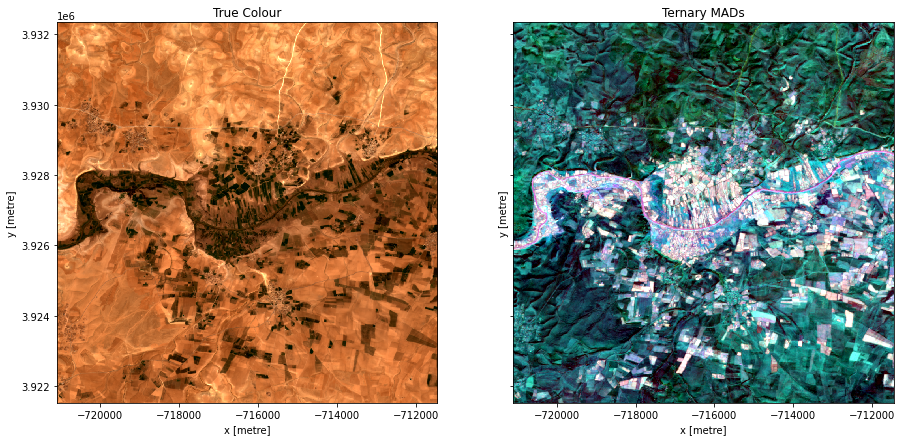

In [11]:
fig,ax=plt.subplots(1,2, sharey=True, figsize=(15,7))
rgb(ds,ax=ax[0])
rgb(ds, bands=['smad','emad','bcmad'],ax=ax[1])
ax[0].set_title('True Colour')
ax[1].set_title('Ternary MADs');

## Example application: Identifying irrigated areas using SMAD

The following section will demonstrate a simple analysis workflow based on the GeoMAD product. In this example, we will threshold the SMAD band to distinguish irrigated agriclutural fields from rain-fed agricultural fields.

First, lets reload our data over the same region as above. We will load the `red`, `green`, and `blue` bands, along with `smad`

In [12]:
# load data
lat, lon = 32.4493, -7.4236
buffer = 0.05

ds = dc.load(product="gm_s2_annual",
             measurements=['red','green','blue','smad'],
             x= (lon-buffer, lon+buffer),
             y=(lat+buffer, lat-buffer),
             time=("2020")
             ).squeeze()
print(ds)

<xarray.Dataset>
Dimensions:      (y: 1081, x: 965)
Coordinates:
    time         datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 3.932e+06 3.932e+06 ... 3.922e+06 3.922e+06
  * x            (x) float64 -7.211e+05 -7.211e+05 ... -7.115e+05 -7.115e+05
    spatial_ref  int32 6933
Data variables:
    red          (y, x) uint16 2940 2948 2945 2934 2888 ... 2940 2903 2879 2862
    green        (y, x) uint16 1798 1802 1803 1795 1772 ... 1916 1893 1876 1858
    blue         (y, x) uint16 1114 1118 1118 1110 1092 ... 1275 1253 1237 1224
    smad         (y, x) float32 0.0002043 0.000197 ... 0.0001852 0.0001878
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


Now plot the `smad` band to see if it is useful for distinguishing between irrigated and non-irrigated fields

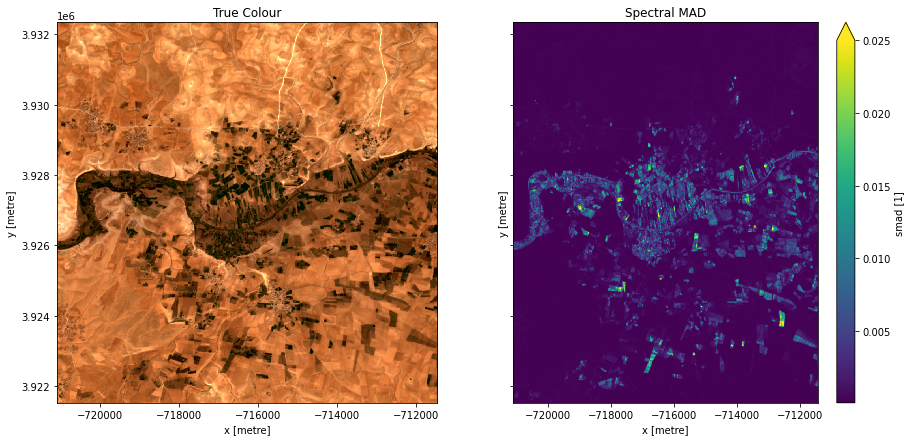

In [13]:
fig,ax=plt.subplots(1,2, sharey=True, figsize=(15,7))
rgb(ds,ax=ax[0])
ds.smad.plot.imshow(vmax=0.025, ax=ax[1])
ax[0].set_title('True Colour')
ax[1].set_title('Spectral MAD');

It looks like `smad` will be useful for identifying irrigation, so lets define a threshold using the `skimage.filters.threshold_li` method. This method will automatically find the optimal threhold based on minimizing the cross-entropy between the foreground and the foreground mean, and the background and the background mean

Threshold:  0.0016189023


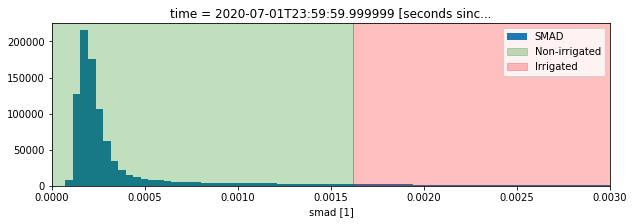

In [14]:
from skimage.filters import threshold_li

#find the threshold
threshold = threshold_li(ds.smad.values)
print("Threshold: ", threshold)

#plot a histogram of the result
fig, ax = plt.subplots(figsize=(10, 3))
ds.smad.plot.hist(bins=1000, label="SMAD")
plt.xlim(0,0.003)
ax.axvspan(xmin=0, xmax=threshold, alpha=0.25, color="green", label="Non-irrigated"),
ax.axvspan(xmin=threshold,
           xmax=0.005,
           alpha=0.25,
           color="red",
           label="Irrigated")
plt.legend();

### Apply the threshold and plot the result

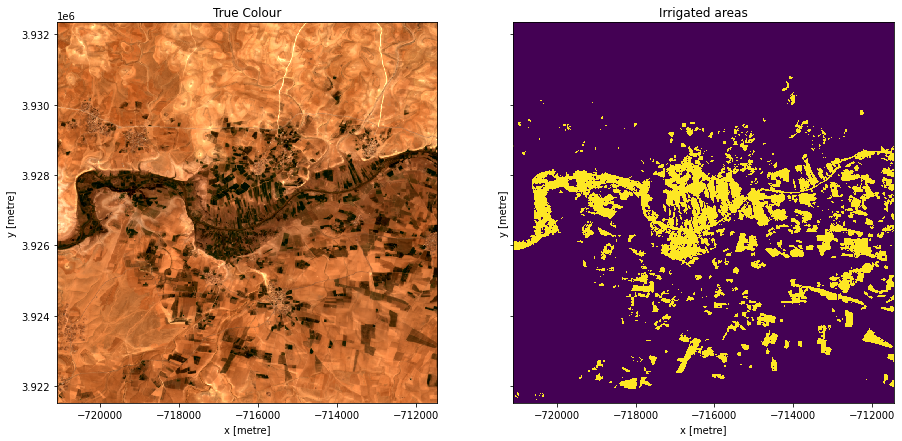

In [15]:
#Apply the threshold
irrigated = ds.smad >= threshold

#plot
fig,ax=plt.subplots(1,2, sharey=True, figsize=(15,7))
rgb(ds,ax=ax[0])
irrigated.plot.imshow(ax=ax[1], add_colorbar=False)
ax[0].set_title('True Colour')
ax[1].set_title('Irrigated areas');

## Interactive widget: Understanding the geomedian

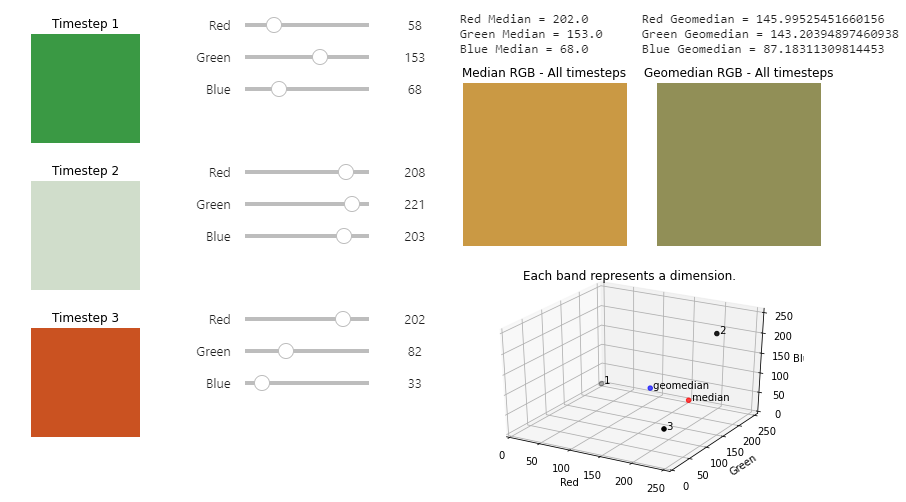

*An example of the geomedian interactive widget.*

> The Digital Earth Africa Docs website is read-only. Log in to the [Digital Earth Africa Sandbox](https://sandbox.digitalearth.africa/) and navigate to the **Datasets** folder > **GeoMAD** to interact with the widget.

In this interactive widget example, you have a dataset of Earth observation satellite data. It contains the red, green, and blue bands, which are the bands generally used to generate colour images. The widget focuses on a single pixel that has data for 3 different timesteps. We can composite (combine) these 3 timesteps into one using a statistical composition method such as `median` or `geomedian`.

This widget shows that the median does **not** always account for very large or very small band values, and may not be particularly representative of the variation we see in the three timesteps. 

Variation is better incorporated into the `Geomedian RGB - All timesteps` result, as the geomedian formula treats each timestep as a multi-dimensional vector. We see this results in differing values between the median and geomedian.

In [16]:
geomedian.run_app()

For example, try:

>Timestep 1: (0,0,0)

>Timestep 2: (0, 255, 0)

>Timestep 3: (255, 255, 255)

The geomedian shows a more representative value that incorporates some of the variation across the timesteps.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [18]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-01'